# Preparation

In this section i will parse the data received from the iPad. I will try to extract the strokes with digits and prepare them for being used by the TensorFlow model. Since the model works with Images, and my data is just a collection of coordinates - i need to do a lot of transformations to make those work.

### Imports

In [51]:
%matplotlib inline

import sys
import json
import math
import numpy as np
import matplotlib.cm as cm
from pprint import pprint as pp
from matplotlib import pyplot as plt

MIN = sys.float_info.min
MAX = sys.float_info.max

### Classes

In [52]:
class Point:
    def __init__(self, x, y, force, aziang, altang, time):
        self.x = x
        self.y = y
        self.force = force
        self.aziang = aziang
        self.altang = altang
        self.time = time
    
    def __str__(self):
        return "({0}, {1})".format(self.x, self.y)
    
    def __repr__(self):
        return self.__str__()

class Stroke:
    def __init__(self):
        self.points = []
        self.order = -1
        self.max_x = MIN
        self.min_x = MAX
        self.max_y = MIN
        self.min_y = MAX
        self.area = 0.0
        self.length = 0
        # Add more parameters/features
        
    def __str__(self):
        return "({0}, {1}, {2})".format(self.order, len(self.points), self.area)
    
    def __repr__(self):
        return self.__str__()
    
    def add_point(self, point):
        self.points.append(point)
    
    #For plotting
    def get_coordinates(self, invertY = True):
        x_coords = []
        y_coords = []
        for point in self.points:
            x_coords.append(point.x)
            y_coords.append(-point.y if invertY else point.y)
        
        return x_coords, y_coords
    
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
              
class Drawing:
    def __init__(self):
        self.strokes = []
        # Other parameters...
        
    def __str__(self):
        return "({0})".format(len(self.strokes))
    
    def __repr__(self):
        return self.__str__()
    
    def add_stroke(self, stroke):
        self.strokes.append(stroke)
        
    def get_stroke(self, order):
        stroke_by_index = self.strokes[order]
        if stroke_by_index.order == order:
            return stroke_by_index
        else:
            print "Order ({0}) is not the same as index ({1})!".format(order, stroke_by_index.order)
            for stroke in self.strokes:
                if stroke.order == order:
                    return stroke
            # throw exception?
            
    def get_borders(self):
        max_x = MIN
        max_x_stroke = -1
        min_x = MAX
        min_x_stroke = -1
        max_y = MIN
        max_y_stroke = -1
        min_y = MAX
        min_y_stroke = -1
        
        for stroke in self.strokes:
            if stroke.max_x > max_x:
                max_x = stroke.max_x
                max_x_stroke = stroke.order
            
            if stroke.max_y > max_y:
                max_y = stroke.max_y
                max_y_stroke = stroke.order
                
            if stroke.min_x < min_x:
                min_x = stroke.min_x
                min_x_stroke = stroke.order
                
            if stroke.min_y < min_y:
                min_y = stroke.min_y
                min_y_stroke = stroke.order
        
        return max_x, max_x_stroke, min_x,min_x_stroke, max_y, max_y_stroke, min_y, min_y_stroke
            
                
class Helper:
    
    @staticmethod
    def euclidean_distance(p, q):
        return math.sqrt((q.x - p.x)**2 + (q.y - p.y)**2)
    
    @staticmethod
    def quadrant(center, p):
        if p.x >= center.x and p.y > center.y:
            return 1
        
        if p.x > center.x and p.y <= center.y:
            return 2
        
        if p.x <= center.x and p.y < center.y:
            return 3
        
        if p.x < center.x and p.y >= center.y:
            return 4
        
    @staticmethod
    def direction(full_direction):
        #todo: maybe regexp?
        if full_direction in "1234123412341234123412341234":
            return "CCW"
        
        if full_direction in "4321432143214321432143214321":
            return "CW"
        
        return "UNKNOWN" # ???

### Extract data from JSON

In [53]:
with open('../clock-data/clock-3-ipad.json') as json_file:
    json_data = json.load(json_file)
    
json_strokes = []
for i in range(0, len(json_data["data"])):
    json_strokes.append(json_data["data"][i])

drawing = Drawing()        

for index, json_stroke in enumerate(json_strokes):
    
    stroke = Stroke()
    
    for json_point in json_stroke:
        if json_point["x"] > stroke.max_x:
            stroke.max_x = json_point["x"]
        if json_point["x"] < stroke.min_x:
            stroke.min_x = json_point["x"]
        if json_point["y"] > stroke.max_y:
            stroke.max_y = json_point["y"]
        if json_point["y"] < stroke.min_y:
            stroke.min_y = json_point["y"]
        
        stroke.add_point(Point(json_point["x"], json_point["y"], json_point["force"], json_point["aziang"], json_point["altang"], json_point["time"]))
    
    stroke.order = index
    stroke.width = stroke.max_x - stroke.min_x
    stroke.height = stroke.max_y - stroke.min_y
    stroke.area = stroke.width * stroke.height
    stroke.length = len(stroke.points)
    
    #TODO: Extract more features
    
    drawing.add_stroke(stroke)
    
print "Number of strokes: {}".format(len(drawing.strokes))
print drawing.strokes
        

Number of strokes: 21
[(0, 101, 280984.0), (1, 12, 116.25), (2, 22, 1805.25), (3, 29, 3071.25), (4, 22, 2436.0), (5, 21, 2764.5), (6, 8, 240.0), (7, 14, 1120), (8, 20, 1647.0), (9, 8, 543.75), (10, 25, 1886), (11, 17, 1134.75), (12, 12, 273.0), (13, 26, 1998.0), (14, 9, 435.0), (15, 18, 1886.5), (16, 10, 132), (17, 9, 134.75), (18, 4, 0.75), (19, 30, 929.5), (20, 21, 5125.5)]


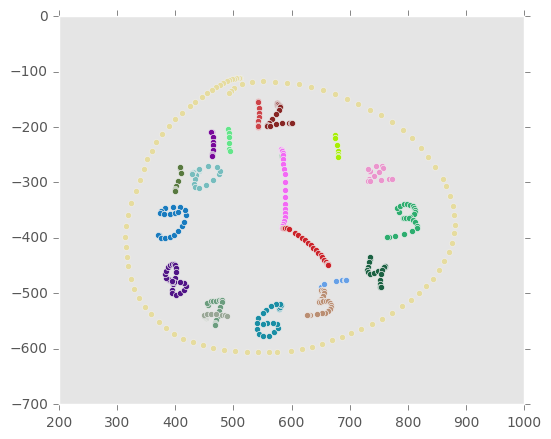

In [54]:
x_coords = []
y_coords = []     

plt.style.use('ggplot')
plt.figure(figsize=(6,5))

for stroke in drawing.strokes:
    for point in stroke.points:
        x_coords.append(point.x)
        y_coords.append(-point.y)
    plt.scatter(x_coords, y_coords, c=np.random.rand(3,1))
    x_coords=[]
    y_coords=[]


# plt.scatter(x_coords, y_coords)
plt.grid()
plt.show()

### Take an example stroke


Length of stroke: 29


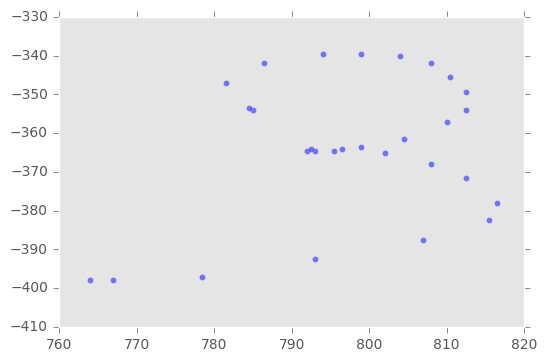

In [183]:
example_stroke = drawing.strokes[3]
print "Length of stroke: {0}".format(example_stroke.length)

x_coords, y_coords = example_stroke.get_coordinates()

plt.scatter(x_coords, y_coords, alpha=0.5)

plt.grid()
plt.show()

### Shrink the stroke

Ratio: 0.34188034188
(11, 5) --> (11, 5)
(11, 5) --> (12, 3)
Both changed!
diff_x: 1, diff_y: -2
X is smaller
1) Adding (12, 4)
y_coord = 5 + -1
************************************
************************************
************************************
(12, 3) --> (10, 1)
Both changed!
diff_x: -2, diff_y: -2
X is smaller
1) Adding (11, 2)
y_coord = 3 + -1
************************************
************************************
************************************
(10, 1) --> (8, 0)
Both changed!
diff_x: -2, diff_y: -1
Y is smaller
1) Adding (9, 0)
************************************
************************************
************************************
(8, 0) --> (6, 0)
Both changed!
diff_x: -2, diff_y: 0
Y is smaller
1) Adding (7, 0)
************************************
************************************
************************************
(6, 0) --> (4, 0)
Both changed!
diff_x: -2, diff_y: 0
Y is smaller
1) Adding (5, 0)
************************************
***************

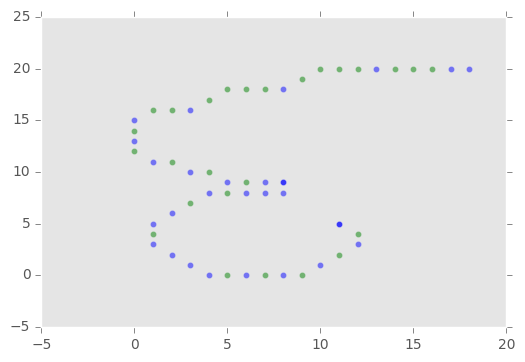

In [184]:

x_coords_shrink = []
y_coords_shrink = []


x_size = example_stroke.max_x - example_stroke.min_x
y_size = example_stroke.max_y - example_stroke.min_y
ratio = 20.0 / max(x_size, y_size) #TODO: Move to constants

print "Ratio: {}".format(ratio)

min_x = 1000000
min_y = 1000000
for point in example_stroke.points:
    new_x = -point.x * ratio # In matrix, x(0) is on the top
    new_y = point.y * ratio
    
    if new_x < min_x:
        min_x = new_x
    
    if new_y < min_y:
        min_y = new_y
    
    x_coords_shrink.append(new_x)
    y_coords_shrink.append(new_y)

x_add_coords = []
y_add_coords = []

x_coords_len = len(x_coords_shrink)
for i, val in enumerate(x_coords_shrink):
    x_coords_shrink[i] = int(round(x_coords_shrink[i] - min_x))
    y_coords_shrink[i] = int(round(y_coords_shrink[i] - min_y))
    
    if i > 0 and i < x_coords_len-1:
        prev_x = x_coords_shrink[i-1]
        prev_y = y_coords_shrink[i-1]
        
        curr_x = x_coords_shrink[i]
        curr_y = y_coords_shrink[i]
        
        diff_x = curr_x - prev_x
        diff_y = curr_y - prev_y
        
        small_x = min(curr_x, prev_x)
        small_y = min(curr_y, prev_y)
        
        print "({0}, {1}) --> ({2}, {3})".format(prev_x, prev_y, curr_x, curr_y)
        
        diff_y_is_negative = diff_y < 0
        diff_x_is_negative = diff_x < 0
        
#         No difference
        if diff_x == 0 and diff_y == 0:
            continue
        
#         # Only Y changed
#         if diff_x == 0:
#             print "Only Y changed:"
#             for i in range(1, abs(diff_y)):
#                 print "Adding ({0}, {1})".format(curr_x, prev_y + (-i if diff_y_is_negative else i))
#                 x_add_coords.append(prev_x)
#                 y_add_coords.append(prev_y + (-i if diff_y_is_negative else i))
                
# #             plt.scatter([prev_x, curr_x], [prev_y, curr_y], c="blue")
# #             plt.scatter(x_add_coords, y_add_coords, c="red")
# #             plt.show()

# #             x_add_coords = [] # REMOVE!
# #             y_add_coords = [] # REMOVE!
            
#             continue
                
#         # Only X changed
#         if diff_y == 0:
#             print "Only X changed:"
#             for i in range(1, abs(diff_x)):
#                 print "Adding ({0}, {1})".format(prev_x + (-i if diff_x_is_negative else i), curr_y)
#                 x_add_coords.append(prev_x + (-i if diff_x_is_negative else i))
#                 y_add_coords.append(prev_y)
                
# #             plt.scatter([prev_x, curr_x], [prev_y, curr_y], c="blue")
# #             plt.scatter(x_add_coords, y_add_coords, c="red")
# #             plt.show()

# #             x_add_coords = [] # REMOVE!
# #             y_add_coords = [] # REMOVE!
            
#             continue
        
        
        print "Both changed!"
        print "diff_x: {0}, diff_y: {1}".format(diff_x, diff_y)
        y_is_smaller = abs(diff_y) < abs(diff_x)
        if y_is_smaller:
            print "Y is smaller"
            last_y = prev_y
            for i in range(1, abs(diff_x)):
                if i <= abs(diff_y):
                    last_y = prev_y + (-i if diff_y_is_negative else i)
                print "1) Adding ({0}, {1})".format(prev_x + (-i if diff_x_is_negative else i), last_y)
                x_add_coords.append(prev_x + (-i if diff_x_is_negative else i))
                y_add_coords.append(last_y)          
        else:
            print "X is smaller"
            last_x = prev_x
            for i in range(1, abs(diff_y)):
                if i <= abs(diff_x):
                    last_x = prev_x + (-i if diff_x_is_negative else i)
                print "1) Adding ({0}, {1})".format(last_x, prev_y + (-i if diff_y_is_negative else i))
                x_add_coords.append(last_x)
                print "y_coord = {0} + {1}".format(prev_y, (-i if diff_y_is_negative else i))
                y_add_coords.append(prev_y + (-i if diff_y_is_negative else i))
        
        
#         plt.scatter([prev_x, curr_x], [prev_y, curr_y], c="blue")
#         plt.scatter(x_add_coords, y_add_coords, c="red")
#         plt.show()
        
#         x_add_coords = [] # REMOVE!
#         y_add_coords = [] # REMOVE!
        
#         change_ratio = float(diff_x) / float(diff_y)
#         print "change ratio {0} / {1} = {2}".format(diff_x, diff_y, change_ratio)  
        
        print "************************************"
        print "************************************"
        print "************************************"
        
        #TODO: Try to change by ration == more accurate
#         # Both X and Y changed
        
#         if change_ratio == 1:
#             for i in range(1, diff_x):
#                 x_add_coords.append(small_x + i)
#                 y_add_coords.append(small_y + i)
#             continue
        
#         if change_ratio == 9: #fix
#             for i in range(1, diff_x):
#                 x_add_coords.append(small_x + i)
#                 if i == 4:
#                     curr_y = curr_y + 1
#                 y_add_coords.append(curr_y)
    
plt.scatter(x_coords_shrink, y_coords_shrink, alpha=0.5)
plt.scatter(x_add_coords, y_add_coords, c="green", alpha=0.5)
plt.grid()
plt.show()

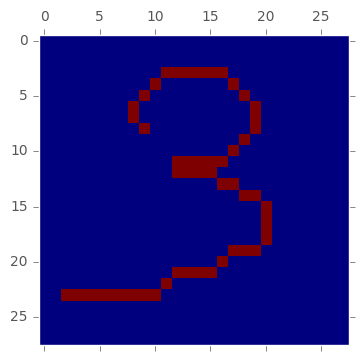

In [185]:
number_matrix = np.zeros((28, 28))

for i, val in enumerate(x_add_coords):
    number_matrix[y_add_coords[i] + 3][20 - x_add_coords[i]] = 1
    
for i, val in enumerate(x_coords_shrink):
    number_matrix[y_coords_shrink[i] + 3][20 - x_coords_shrink[i]] = 1
    
plt.matshow(number_matrix)
plt.grid()
plt.show()

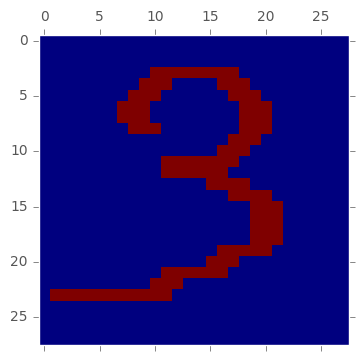

In [186]:

### Make digit "thick"

row_dict = {}

for num, row in enumerate(number_matrix):
    if 1 in row:
        for index, item in enumerate(row):
            if item == 1:
                if num not in row_dict:
                    row_dict[num] = []
                row_dict[num].append(index-1)
                row_dict[num].append(index+1)
                
for key in row_dict.keys():
    for index in row_dict[key]:
        if index > -1 and index < 28:
            number_matrix[key][index] = 1

        
plt.matshow(number_matrix)
plt.grid()
plt.show()

# Machine Learning part

### Imports

In [10]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

### Constants

In [38]:
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 5000 # set to 20000 to get 0.99 accuracy
DROPOUT = 0.5
BATCH_SIZE = 50
VALIDATION_SIZE = 2000 # set to 0 to train on all available data
IMAGE_TO_DISPLAY = 10

### Load and prepare the MNIST data

In [12]:
data = pd.read_csv('../MNIST_DATA/csv/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [13]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [14]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


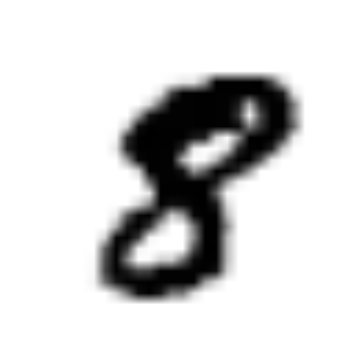

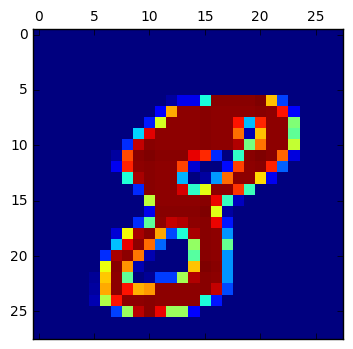

In [15]:
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.matshow(one_image)

# output image     
display(images[IMAGE_TO_DISPLAY])

In [16]:
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


In [17]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [18]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [19]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


### TensorFlow configuration

In [20]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [21]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

In [22]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

In [23]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [24]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [25]:

# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

In [26]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [27]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

### Training & Testing

In [28]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [29]:
# Load session from file?


# saver = tf.train.import_meta_graph("digit-recognizer.ckpt.meta")
# with tf.Session() as sess:
#     saver.restore(sess, "digit-recognizer.ckpt")
#     print("Model Restored")
    

In [40]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

In [41]:

# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.12 / 0.06 for step 0
training_accuracy / validation_accuracy => 0.04 / 0.12 for step 1
training_accuracy / validation_accuracy => 0.04 / 0.12 for step 2
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 3
training_accuracy / validation_accuracy => 0.06 / 0.12 for step 4
training_accuracy / validation_accuracy => 0.12 / 0.12 for step 5
training_accuracy / validation_accuracy => 0.12 / 0.12 for step 6
training_accuracy / validation_accuracy => 0.16 / 0.12 for step 7
training_accuracy / validation_accuracy => 0.16 / 0.12 for step 8
training_accuracy / validation_accuracy => 0.08 / 0.12 for step 9
training_accuracy / validation_accuracy => 0.10 / 0.14 for step 10
training_accuracy / validation_accuracy => 0.38 / 0.30 for step 20
training_accuracy / validation_accuracy => 0.56 / 0.60 for step 30
training_accuracy / validation_accuracy => 0.60 / 0.64 for step 40
training_accuracy / validation_accuracy => 0.82 / 0.70 for step 50
train

In [32]:
# Save session to file?

# saver = tf.train.Saver()

# save_path = saver.save(sess, "digit-recognizer-test.ckpt")

validation_accuracy => 0.9845


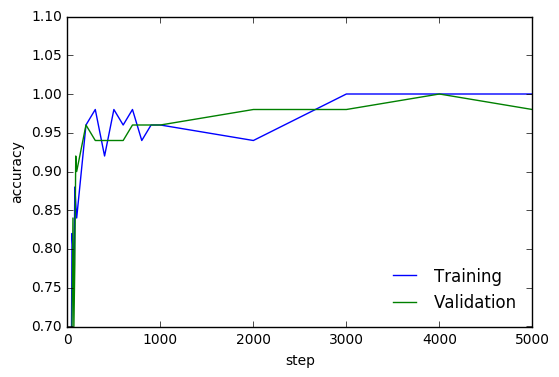

In [42]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0
OK!


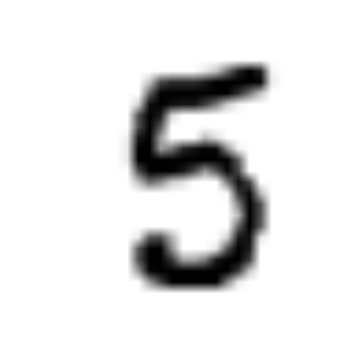

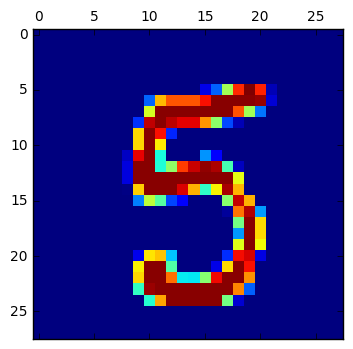

In [43]:
# read test data from CSV file 
test_images = pd.read_csv('../MNIST_DATA/csv/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)
print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))
print ("OK!")

# save results
# np.savetxt('submission_softmax.csv', 
#            np.c_[range(1,len(test_images)+1),predicted_lables], 
#            delimiter=',', 
#            header = 'ImageId,Label', 
#            comments = '', 
#            fmt='%d')


# Predicting my stroke

In [11]:
number_vector = number_matrix.reshape(1, 784)

# predicted_lables_my = predict.eval(feed_dict={x: number_vector, keep_prob: 1.0})
# print "My number prediction: {0}".format(predicted_lables_my)

# plt.matshow(number_matrix)
# plt.grid()
# plt.show()

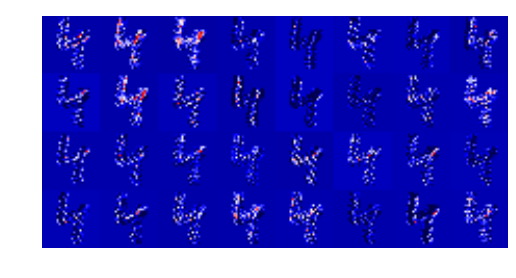

In [45]:
layer1_grid = layer1.eval(feed_dict={x: number_vector, keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )
plt.show()

In [46]:
saver = tf.train.Saver()

save_path = saver.save(sess, "digit-recognizer-new.ckpt")

In [15]:
print(number_vector[0])

new_vect = [];
test_vect = [];
for item in number_vector[0]:
    if item == 0:
        new_vect.append(255)
        test_vect.append(0)
    else:
        new_vect.append(0)
        test_vect.append(1)
        
print (new_vect)
print (test_vect)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0